<a href="https://colab.research.google.com/github/EmYassir/rl_optimal_control/blob/main/Measles_BVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.optimize import minimize

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

#  Seasonal Outbreaks of Measles

The following example is taken from [Numerical solution of boundary value problems for ordinary differential equations](https://books.google.ca/books?id=0RvOrnO4WgwC&lpg=PP1&dq=Numerical%20solution%20of%20boundary%20value%20problems%20for%20ordinary%20differential%20equations%20Robert%20D.%20Russell&pg=PA14#v=onepage&q=measles&f=false) by Uri M. Ascher , Robert M. M. Mattheij and Robert D. Russell. According to the bibliographical remarks, this model is based on [Schwartz (1983)](https://doi.org/10.1137/0720008); you can in indeed find the description of this model on page 116 of the Schwartz (1983) paper.  And if you read carefully the Schwartz (1983) paper, you finally see that this model is based on [London and Yorke (1973)](https://doi.org/10.1093/oxfordjournals.aje.a121575
)

This model assumes that population stays constant and can be partitioned into *susceptible* cases $S(t)$ (people who can contract measles), *infectives* $I(t)$ (people who can infect other people), *latents* $L(t)$ (people who have measles but can't spread it yet) and *immunes* $M(t)$ (recovered cases). Furthermore, it is assumed that that the disease is non lethal and that the births exactly counterbalance all other deaths. In this problem, we set the birth rate $\mu$ to $2\%$ of the total population $N$. At all times for $t \in [0, 1]$, we have: 
\begin{align*}
S(t) + I(t) + L(t) + M(t) = N \enspace ,
\end{align*}
where $N$ is the total population. Furthermore, the dynamics for this model are given by: 
\begin{align*}
\dot{x}_1 &= \mu - \beta(t)x_1x_3 \\
\dot{x}_2 &= \beta(t)x_1x_3 - \frac{x_2}{\lambda} \\
\dot{x}_3 &= \frac{x_2}{\lambda} - \frac{x_3}{\eta}, \enspace 0 < t < 1 \\
\beta(t) &= \beta_0(1 + \cos(2\pi t))\enspace .
\end{align*}
The boundary condition consists in: 
\begin{align*}
x(1) - x(0) = 0 \enspace .
\end{align*}
This means that we want to find a value for the initial conditions such that at the end of the interval at $t=1$ we got back to the same point: a periodic solution. In this model, $\eta=0.01$ is the mean length of the infectious period in years (3 to 4 days) and $\lambda=0.0029$ is the mean length of the latent period (about 10 to 11 days). The function $\beta(t)$ gives us the *contact rate*, which London and Yorke (1973) desribe as the proportion of susceptible cases that are contacted every year by an average infective individual. 

In [ ]:
def make_measles_bvp(mu=0.02, lmbda=0.0279, eta=0.01, beta0=1575.):
  """
    Args:
      mu (float): Population birth rate
      lmbda (float): Latent period in years (default)
      eta (float): Infectious period in years
      beta (float): Contact rate constant
  """

  def measles_dynamics(t, x):
    x1, x2, x3 = x   # proportions of susceptibles, infectives and latents
    beta_t = beta0*(1. + np.cos(2*np.pi*t)) # contact rate
    dot_x1 = mu - beta_t*x1*x3 
    dot_x2 = beta_t*x1*x3 - x2/lmbda
    dot_x3 = x2/lmbda - x3/eta
    return np.asarray((dot_x1, dot_x2, dot_x3)) # susceptibles, infectives and latents

  def boundary_condition(xinit, xfinal):
    return xfinal - xinit

  return measles_dynamics, boundary_condition, 0., 1.

We can solve this BVP using [scipy.integrate.solve_bvp](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.solve_bvp.html) which according to the documentation uses a 4-th order collocation approach described in [Kierzenka and Shampine (2001)](https://dl.acm.org/doi/pdf/10.1145/502800.502801).

In [ ]:
from scipy.integrate import solve_bvp

dynamics, boundary_condition, initial_time, terminal_time = make_measles_bvp()

mesh = np.linspace(initial_time, terminal_time, 100)
guess = np.ones((mesh.shape[0], 3))*np.array([1, 1, 1])
solution = solve_bvp(dynamics, boundary_condition, mesh, guess.T)
print(solution.y[:,-1])

[7.52362906e-02 1.79844367e-05 4.97392853e-06]


We can then reproduce the [plot](https://www.nag.co.uk/numeric/mb/nagdoc_mb/manual_25_1/pdf/d02/d02tv.pdf) found in the documentation of the [NAG library](https://www.nag.com/content/nag-library). In this plot, the infectious trajectory is in shown on the left y-axis while the infective and latent trajectories are shown on a semi log scale on the right y-axis.

In [ ]:
def plot_measles_bvp(time, x):
  fig, ax = plt.subplots()

  ax.grid(True)
  ax.set_xlabel('Time')
  ax.set_title('Model of Spread of Measles')

  ax.set_ylabel('Susceptible', color='tab:blue')
  ax.tick_params(axis='y', labelcolor='tab:blue')
  ax.set_ylim([0.06, 0.08])
  ax.set_yticks(np.linspace(0.06, 0.08, 5))
  ax.plot(time, x[0,:], c='tab:blue', label='Susceptible')
  ax.legend(loc='lower left')

  rhs_ax = ax.twinx()
  rhs_ax.set_ylim([1e-10, 1])
  rhs_ax.set_ylabel('Infective and Latent', color='tab:orange')
  rhs_ax.tick_params(axis='y', labelcolor='tab:orange')
  rhs_ax.semilogy(time, x[1,:], c='tab:orange', linestyle='dotted', label='Infective')
  rhs_ax.semilogy(time, x[2,:], c='tab:orange', linestyle=(0, (3, 1, 1, 1, 1, 1)), label='Latent')
  rhs_ax.legend(loc='upper right')


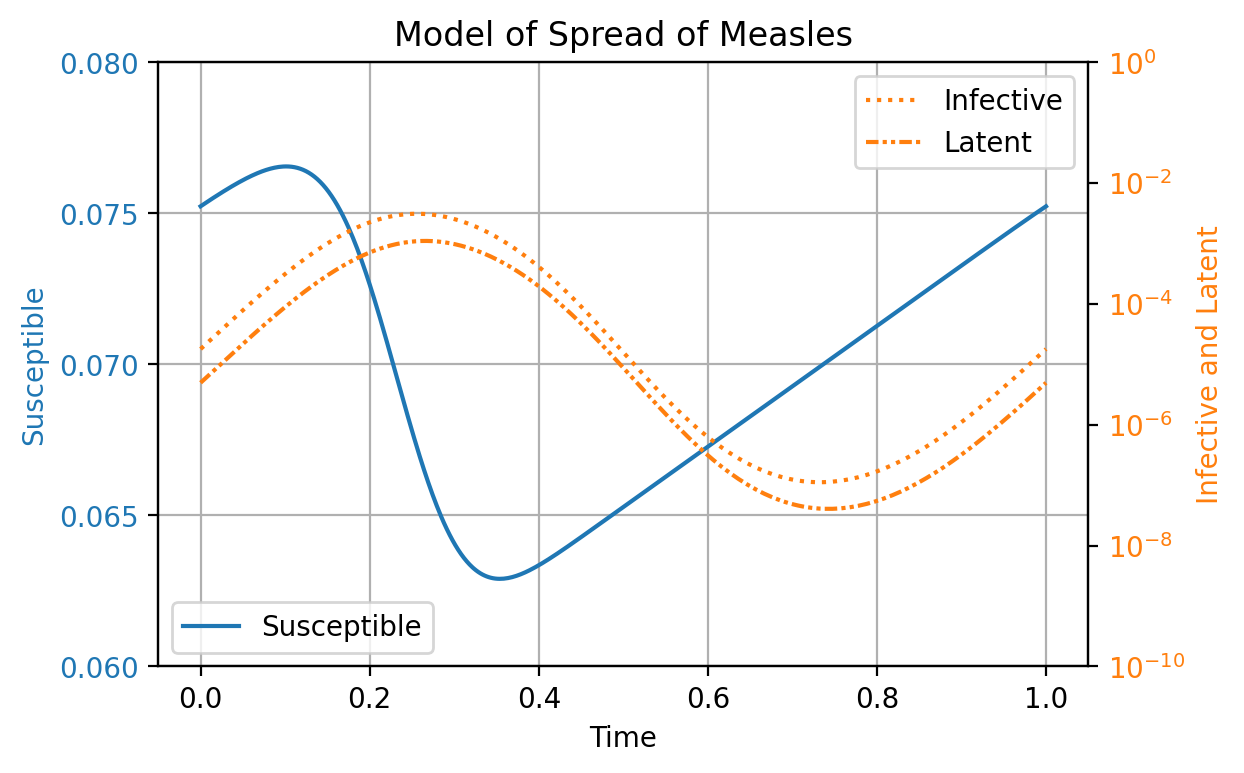

In [ ]:
plot_measles_bvp(solution.x, solution.y)

# Multiple Shooting Method

In multiple shooting methods, we pick $N$ intervals such that $t_\text{init} = t_1 < ... < t_{N} < t_\text{term}$. We then solve the IVP corresponding to each interval. The initial condition $x_{t_i}$ at the begining of interval becomes an optimization variable and we solve for corresponding IVP until $t_{i+1}$. We then need to make sure that the endpoint is the initial condition of the other interval. To ensure that the overall solution is consistent, we require that:
\begin{align*}
\phi_{t_{i+1}}(x_{t_i}) - x_{t_{i+1}} = 0 \enspace .
\end{align*}

In [ ]:
def rk4_step(f, t, x, h):
  k1 = h*f(t, x)
  k2 = h*f(t + h/2, x + k1/2)
  k3 = h*f(t + h/2, x + k2/2)
  k4 = h*f(t + h, x + k3)
  return (1/6)*(k1 + 2*k2 + 2*k3 + k4)

def integrate_equal(method, f, x0, start, stop, num):
  x, t = x0, start
  yield t, x

  h = (stop - start)/(num - 1)
  for _ in range(num - 1):
    x = x + method(f, t, x, h)
    t = t + h
    yield t, x

In [ ]:
def make_multiple_shoooting(dynamics, boundary_condition, initial_time, terminal_time, number_nodes, number_subnodes):
  number_intervals = number_nodes - 1
  nodes = np.linspace(initial_time, terminal_time, number_nodes)
  #print(nodes)
  
  def dummy_objective(initial_conditions):
    return 1.

  def constraint(node_values):
    node_values = np.reshape(node_values, (number_nodes, -1))
    #print(node_values)
    # IMPLEMENT: Compute defects, bc
    # NOTE: Don't forget to np.ravel the output. SLSQP needs flat array
    defects, i = [], 1
    while i < number_nodes:
      data = np.asarray(list(integrate_equal(rk4_step, dynamics, node_values[i - 1], nodes[i - 1], nodes[i], number_subnodes)))
      defects.append(data[-1,-1] - node_values[i])
      i += 1
    
    # We don't forget the boundary condition at the end
    defects.append(boundary_condition(node_values[0], data[-1,-1]))
    defects = np.array(defects)

    return np.ravel(defects)

  return dummy_objective, constraint

In [ ]:
fun, constraint = make_multiple_shoooting(*make_measles_bvp(), 3, 100)

initial_node_values = np.ones((3, 3))*1e-3
solution = minimize(fun, np.ravel(initial_node_values), method='SLSQP', constraints={'type':'eq', 'fun':constraint})
print(solution)

     fun: 1.0
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 333
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([7.52310819e-02, 1.80076009e-05, 4.98076625e-06, 6.52730779e-02,
       1.58817964e-05, 8.80655686e-06, 7.52310819e-02, 1.80076009e-05,
       4.98076625e-06])


In [ ]:
def plot_solution(dynamics, initial_condition, initial_time, terminal_time, nsteps):
  data = np.asarray(list(integrate_equal(rk4_step, dynamics, initial_condition, initial_time, terminal_time, nsteps)))
  plot_measles_bvp(data[:,0], np.vstack(data[:,1]).T)

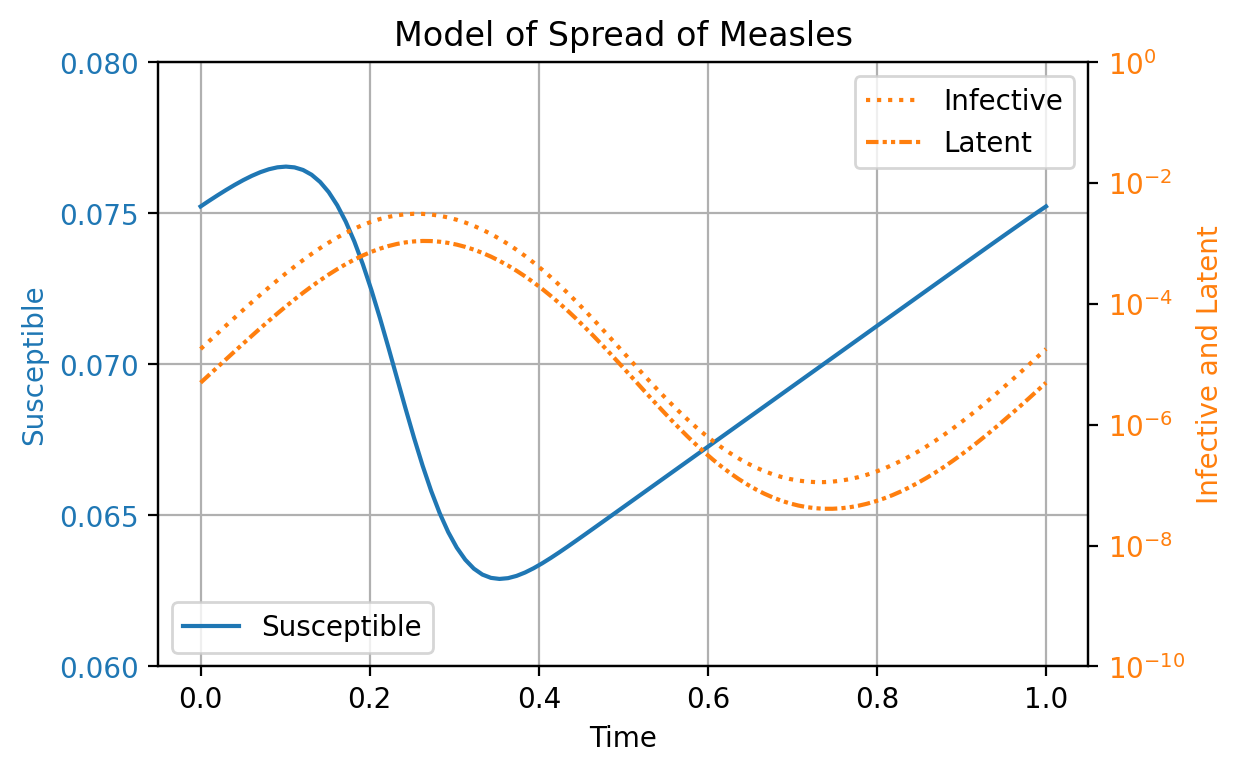

In [ ]:
node_values = np.reshape(solution.x, (3, -1))
plot_solution(dynamics, node_values[0,:], initial_time, terminal_time, 100)